# Taxi Travel Data Analysis

In this demo, we will be doing some demos on temporal feature engineering with the Kaggle Dataset

### Loading libraries, datasets

In [115]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import torch

In [116]:
# These are all of the files you are given
# df_tr = pd.read_csv("archive/train.csv")


In [117]:
# df_tr["ORIGIN_CALL"].value_counts()

In [118]:
#df_tr.head()
# avg = df_tr['LEN'].mean()
# print(avg)

### Get Computed Time from POLYLINE

Our goal is to predict the travel-time of the taxi, which can be derived from the POLYLINE length.

Recall:

```
The travel time of the trip (the prediction target of this project) is defined as the (number of points-1) x 15 seconds. 
For example, a trip with 101 data points in POLYLINE has a length of (101-1) * 15 = 1500 seconds. Some trips have missing 
data points in POLYLINE, indicated by MISSING_DATA column, and it is part of the challenge how you utilize this knowledge.
```

We are not doing anything with the MISSING_DATA. It is up to you to find a way to use (or ignore) that information.

In [119]:
# Over every single 
def polyline_to_trip_duration(polyline):
  return max(polyline.count("[") - 2, 0) * 15

# This code creates a new column, "LEN", in our dataframe. The value is
# the (polyline_length - 1) * 15, where polyline_length = count("[") - 1
# df_tr["LEN"] = df_tr["POLYLINE"].apply(polyline_to_trip_duration)

In [120]:
from datetime import datetime
def parse_time(x):
  # We are using python's builtin datetime library
  # https://docs.python.org/3/library/datetime.html#datetime.date.fromtimestamp

  # Each x is essentially a 1 row, 1 column pandas Series
  dt = datetime.fromtimestamp(x["TIMESTAMP"])
  return dt.year, dt.month, dt.day, dt.hour, dt.weekday()

# Because we are assigning multiple values at a time, we need to "expand" our computed (year, month, day, hour, weekday) tuples on 
# the column axis, or axis 1
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html
# df_tr[["YR", "MON", "DAY", "HR", "WK"]] = df_tr[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")
def parse_midnight_minutes(x):
    dt = datetime.fromtimestamp(x["TIMESTAMP"])
    return dt.hour * 60 + dt.minute

In [121]:
def onehot(x):
    x=x.values[0]
    if x=="A":
        return 1, 0, 0
    elif x=="B":
        return 0, 1, 0
    elif x=="C":
        return 0, 0, 1
    else:
        return 0, 0, 0
    
# df_tr[["CALL_A", "CALL_B", "CALL_C"]] = df_tr[["CALL_TYPE"]].apply(onehot, axis=1, result_type="expand")   
# df_tr[["DAY_A", "DAY_B", "DAY_C"]] = df_tr[["DAY_TYPE"]].apply(onehot, axis=1, result_type="expand")     


### Create a Prediction File

In [122]:
# vals = df_tr["HR"].value_counts()
# print(vals)
# def reduce(x):
#     return x - 2013
# hr_oh = torch.nn.functional.one_hot(torch.tensor(df_tr["HR"].values))
# print(hr_oh)
# print(hr_oh.shape)

In [123]:
# vals = df_tr["TAXI_ID"].values
# print(vals)
# print(min(vals))
# print(max(vals))

# # df_tr["TAXI_ID"] = df_tr["TAXI_ID"].apply(reduce)
# vals = df_tr["TAXI_ID"].values
# print(vals)
# print(min(vals))
# print(max(vals))
# oh = torch.nn.functional.one_hot(torch.tensor(df_tr["TAXI_ID"].values))
# print(oh)
# print(oh.shape)


In [124]:
# df_tr[["CALL_A", "LEN"]].values

In [125]:
# Feature Trimming
# mean, std = df_tr["LEN"].mean(), df_tr["LEN"].std()
# median = df_tr["LEN"].median()
# outlier_threshold = 3
# df_trimmed = df_tr[df_tr["LEN"] < mean + outlier_threshold * std]
# df_trimmed = df_trimmed[df_trimmed['MISSING_DATA'] == False]
# print("Before Trimming: " + str(len(df_tr)))
# print("After Trimming: " + str(len(df_trimmed)))

# df_tr = df_trimmed

In [126]:
df_tr = pd.read_csv("archive/train.csv")
df_tr["LEN"] = df_tr["POLYLINE"].apply(polyline_to_trip_duration)
mean, std = df_tr["LEN"].mean(), df_tr["LEN"].std()
outlier_threshold = 3
df_trimmed = df_tr[df_tr["LEN"] < mean + outlier_threshold * std]
df_trimmed = df_trimmed[df_trimmed['MISSING_DATA'] == False]
df_trimmed = df_trimmed[df_trimmed['LEN'] != 0]
print("Before Trimming: " + str(len(df_tr)))
print("After Trimming: " + str(len(df_trimmed)))
df_tr = df_trimmed
trlen = len(df_tr)

df_ts = pd.read_csv("archive/test_public.csv")
df_ts["POLYLINE"]="trololololo"



df_both = pd.concat([df_tr, df_ts])
df_both["LEN"] = df_both["POLYLINE"].apply(polyline_to_trip_duration)
# # df_tr[["YR", "MON", "DAY", "HR", "WK"]] = df_tr[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")
#df_both["MIDMINS"] = df_both[["TIMESTAMP"]].apply(parse_midnight_minutes, axis=1, result_type="expand")
#df_tr["MIDMINS"]=(df_tr["MIDMINS"]-df_tr["MIDMINS"].min())/(df_tr["MIDMINS"].max()-df_tr["MIDMINS"].min())
df_both = pd.get_dummies(data=df_both, columns=['CALL_TYPE', "DAY_TYPE", "ORIGIN_STAND"])


df_tr = df_both.iloc[:trlen]
df_ts = df_both.iloc[trlen:]






Before Trimming: 1710670
After Trimming: 1656255


In [133]:

class MyDataset(Dataset):
  def __init__(self, df):

    boolcols = list(df.columns)
    badcols = ["TRIP_ID", 'ORIGIN_CALL',  'TIMESTAMP', 'MISSING_DATA', 'POLYLINE', 'LEN', "TAXI_ID"] 
    for b in badcols:
      boolcols.remove(b)
    # print(boolcols)
    
    
         
    boolz=df[boolcols].values
    # intz = df["MIDMINS"].values
    # print(boolz)
    y=df["LEN"].values

    booltens = torch.tensor(boolz,dtype=torch.float32)
    # inttens = torch.tensor(intz,dtype=torch.float32).unsqueeze(1)

    # print(booltens.shape)
    # print(inttens.shape)
 
    self.x_train=torch.cat([booltens], dim=1)
    # print(self.x_train)
    self.y_train=torch.tensor(y,dtype=torch.float32)
    self.df = df
 
  def __len__(self):
    return len(self.y_train)
   
  def __getitem__(self,idx):
    return self.x_train[idx],self.y_train[idx]

In [134]:
from torch.utils.data import random_split
trds=MyDataset(df_tr)
trds, valds = random_split(trds, [0.9, 0.1])
print(len(trds), len(valds))
train_loader=DataLoader(trds,batch_size=256, shuffle=True)
val_loader=DataLoader(valds)

1490630 165625


In [197]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten(start_dim=1)
        # self.conv1 = nn.Conv2d(3, 6, 5)
        # self.pool = nn.MaxPool2d(2, 2)
        # self.conv2 = nn.Conv2d(6, 16, 5)
        self.dro = nn.Dropout(p=0.1)
        self.fc1 = nn.Linear(67, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(1000, 1000)
        self.fc5 = nn.Linear(1000, 1000)
        self.fc6 = nn.Linear(1000, 1000)
        self.fc7 = nn.Linear(64, 1)

    def forward(self, x):

        
        x = F.relu(self.fc1(x))
        x = self.dro(x)
        x = F.relu(self.fc2(x))
        x = self.dro(x)
        x = F.relu(self.fc3(x))
        x = self.dro(x)
        x = self.fc7(x)
        # x = torch.transpose(x, 0, 1)
        return x


net = Net()

In [198]:
import torch.optim as optim
def RMSELoss(yhat,y):
    return torch.sqrt(torch.mean((yhat-y)**2))
criterion = RMSELoss
optimizer = optim.Adam(net.parameters(), lr=0.00001)

In [199]:
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        labels=labels.unsqueeze(1)
        outputs = net(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            #print(outputs[0], labels[0])
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 792.850
[1,  4000] loss: 788.219
[2,  2000] loss: 737.236
[2,  4000] loss: 669.212
[3,  2000] loss: 476.232
[3,  4000] loss: 417.278
[4,  2000] loss: 402.745
[4,  4000] loss: 399.164
[5,  2000] loss: 397.744
[5,  4000] loss: 397.345
Finished Training


In [200]:
with torch.no_grad():
    total_loss = 0.0
    for i, data in enumerate(val_loader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data


        # forward + backward + optimize
        labels=labels
        outputs = net(inputs)
        
        loss = criterion(outputs, labels)


        # print statistics
        total_loss += loss.item()
        # if i%1000==0:
        #     print(round(loss.item()), outputs, labels)

print(f'Total Loss: {total_loss / len(val_loader):.3f}')


Total Loss: 294.222


In [201]:
testset = MyDataset(df_ts)
testloader = DataLoader(testset)
preds = []
with torch.no_grad():
    for data in testloader:
        features, labels = data
        # calculate outputs by running images through the network
        output = net(features)
        preds.append(output.item())
ids = testset.df["TRIP_ID"]        
print(preds)
d = {"TRIP_ID" : ids, "TRAVEL_TIME" : preds}
newdf = pd.DataFrame(d)
print(newdf)
newdf.to_csv("my_pred.csv", index=None)

[688.6246337890625, 681.5244750976562, 800.0953369140625, 605.49951171875, 693.5933837890625, 740.114501953125, 686.173095703125, 679.2530517578125, 684.0123291015625, 725.7243041992188, 584.40576171875, 713.47900390625, 814.737060546875, 724.6161499023438, 767.8038940429688, 565.3872680664062, 683.12841796875, 706.582275390625, 828.2409057617188, 619.4541015625, 724.8526611328125, 723.9116821289062, 655.205078125, 788.5558471679688, 702.728515625, 737.872802734375, 744.2264404296875, 770.437255859375, 589.059814453125, 697.7022705078125, 753.7406616210938, 640.098388671875, 707.7645263671875, 665.2540893554688, 671.4915161132812, 806.5391845703125, 793.90966796875, 574.1136474609375, 704.1141357421875, 601.9242553710938, 528.1742553710938, 675.5418701171875, 687.898681640625, 759.4838256835938, 645.9367065429688, 585.3226318359375, 733.3452758789062, 621.5887451171875, 643.9556884765625, 614.5603637695312, 681.1346435546875, 606.7177734375, 568.3596801757812, 796.90673828125, 744.8865

In [202]:
# # Sample submission file that is given on kaggle
# df_sample = pd.read_csv("archive/sampleSubmission.csv")

# df_sample["TRAVEL_TIME"] = 716.43

# # mean(716.43) -> 792.73593
# # median(600) -> 784.74219
# df_sample.to_csv("my_pred.csv", index=None)

### Do some Feature Analysis

For our feature analysis, we are looking at which of our engineered features may be useful in making a taxicab time regression model

Using: 1656255/1656255


KeyError: ['YR']

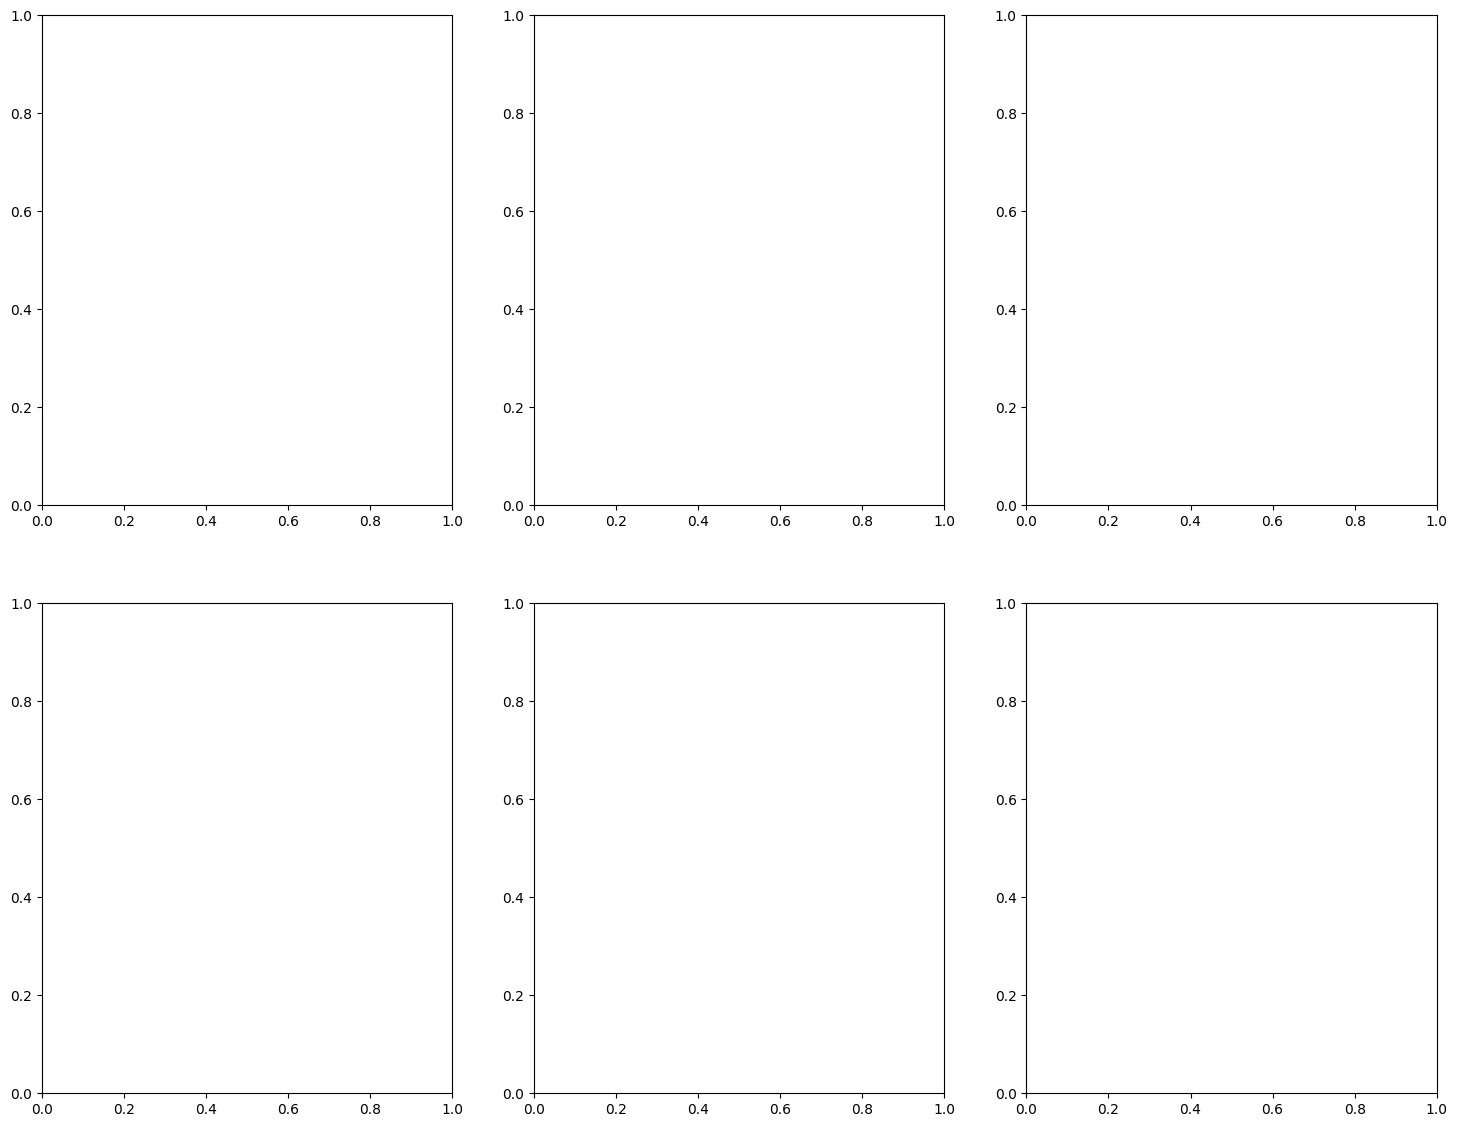

In [203]:
# First n samples to analyze. Set to -1 to use all data
end = -1

outlier_threshold = 3

# "Choose all data, where the trip length is less than 3 standard deviations away from the mean"
# This is to remove outliers. Otherwise, our plots would look very squished (since there are some
# VERRRRRY long taxi trips in the dataset)
df_trimmed = df_tr[df_tr["LEN"] < mean + outlier_threshold * std]

# Because our y-values only take on multiples of 15, we want just enough buckets in a histogram
# such that each buckets counts one value's frequency. (e.x. one bucket counts how many 15s trips, 
# how many 30s trips, etc. )
buckets = (int(mean + outlier_threshold * std) // 15)

print(f"Using: {len(df_trimmed)}/{len(df_tr)}")

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,14))

# Now, we visualize some features that we think might be useful
for idx, v in enumerate(["YR", "MON", "DAY", "HR", "WK", "ORIGIN_STAND"]):
  # idx // 3 = row, idx % 3 = column
  ax = axs[idx // 3, idx % 3]
  
  # Remove any rows with invalid values
  df_subset = df_trimmed.dropna(subset=v)
  
  # Create a histogram. Look up the documentation for more details
  ax.hist2d(df_subset[v][:end], df_subset["LEN"][:end], cmap="CMRmap", bins=(120,buckets))
  
  # Some stylistic things to make the graphs look nice
  ax.set_xlim(ax.get_xlim()[0] - 1, ax.get_xlim()[1] + 1)
  ax.set_facecolor("black")
  ax.set_ylabel("seconds", fontsize=18)
  ax.set_title(f"Feature: {v}", fontsize=20)


In [ ]:
plt.figure(figsize=(10,10))
for v in [0, 5, 11, 17, 23]:
  # Filter data where the HR matches v
  hourly_data = df_trimmed[df_trimmed["HR"] == v]["LEN"]
  histogram, bin_boundary = np.histogram(hourly_data, bins=buckets)
  histogram = histogram / len(hourly_data)
  # The center is the left_bound and right_bound of a bucket
  bin_centers = [(bin_boundary[i] + bin_boundary[i + 1]) / 2 for i in range(buckets)]
  plt.plot(bin_centers, histogram, label=f"HR={v}")
plt.legend();